In [74]:
from kaggle_environments import make, utils
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import choice
import seaborn as sns
import sys

env = make("connectx", debug=True)
trainer = env.train([None, "random"])
env.render(mode="ipython", width=350, height=300)

In [32]:
print(env.state)

[{'action': 0, 'reward': 0, 'info': {}, 'observation': {'remainingOverageTime': 60, 'step': 0, 'board': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'mark': 1}, 'status': 'ACTIVE'}, {'action': 0, 'reward': 0, 'info': {}, 'observation': {'remainingOverageTime': 60, 'mark': 2}, 'status': 'INACTIVE'}]


In [ ]:
env.state[0].keys()

In [30]:
env.state[0].values()

dict_values([0, 0, {}, {'remainingOverageTime': 60, 'step': 0, 'board': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'mark': 1}, 'ACTIVE'])

In [45]:
class QTable():
    def __init__(self, actions):
        self.Q = {}
        self.actions = actions
        
    def get_state_key(self, state):
        board = state.board[:]
        board.append(state.mark)
        state_key = np.array(board).astype(str)
        return hex(int(''.join(state_key), 3))[2:]
    
    def get_q_values(self, state):
        state_key = self.get_state_key(state)
        if state_key not in self.Q.keys():
            self.Q[state_key] = [0] * len(self.actions)
        return self.Q[state_key]
    
    def update(self, state, action, add_q):
        state_key = self.get_state_key(state)
        self.Q[state_key] = [q + add_q if idx == action else q for idx, q in enumerate(self.Q[state_key])]

In [54]:
class QLearningAgent():
    def __init__(self, env, epsilon=0.99):
        self.env = env
        self.actions = list(range(self.env.configuration.columns))
        self.q_table = QTable(self.actions)
        self.epsilon = epsilon
        self.reward_log = []    
        
    def policy(self, state):
        if np.random.random() < self.epsilon:
            # epsilonの割合で、ランダムにactionを選択する
            return choice([c for c in range(len(self.actions)) if state.board[c] == 0])
        else:
            # ゲーム上選択可能で、Q値が最大なactionを選択する
            q_values = self.q_table.get_q_values(state)
            selected_items = [q if state.board[idx] == 0 else -1e7 for idx, q in enumerate(q_values)]
            return int(np.argmax(selected_items))
        
    def custom_reward(self, reward, done):
        if done:
            if reward == 1: # 勝ち
                return 20
            elif reward == 0: # 負け
                return -20
            else: # 引き分け
                return 10
        else:
            return -0.05 # 勝負がついてない
        
    def learn(self, trainer, episode_cnt=10000, gamma=0.6, 
              learn_rate=0.3, epsilon_decay_rate=0.9999, min_epsilon=0.1):
        for episode in tqdm(range(episode_cnt)):
            # ゲーム環境リセット
            state = trainer.reset() 
            # epsilonを徐々に小さくする
            self.epsilon = max(min_epsilon, self.epsilon * epsilon_decay_rate) 
            while not env.done:
                # どの列にドロップするか決めるて実行する
                action = self.policy(state) 
                next_state, reward, done, info = trainer.step(action)
                reward = self.custom_reward(reward, done)
                # 誤差を計算してQテーブルを更新する
                gain = reward + gamma * max(self.q_table.get_q_values(next_state))
                estimate = self.q_table.get_q_values(state)[action]
                self.q_table.update(state, action, learn_rate * (gain - estimate)) 
                state = next_state
      
            self.reward_log.append(reward)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [08:21<00:00, 19.95it/s]


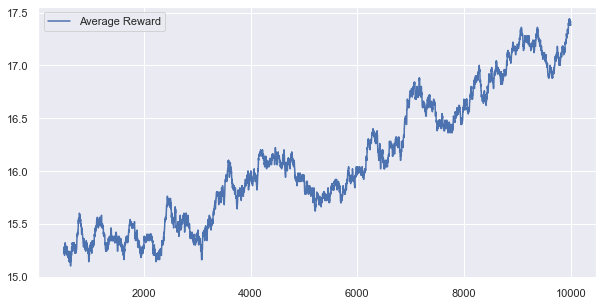

In [55]:
qa = QLearningAgent(env)
qa.learn(trainer)

# ゲーム終了時に得られた報酬の移動平均

sns.set(style='darkgrid')
pd.DataFrame({'Average Reward': qa.reward_log}).rolling(500).mean().plot(figsize=(10,5))
plt.show()

In [70]:
tmp_dict_q_table = qa.q_table.Q.copy()
dict_q_table = dict()

# 学習したQテーブルで、一番Q値の大きいActionに置き換える
for k in tmp_dict_q_table:
    if np.count_nonzero(tmp_dict_q_table[k]) > 0:
        dict_q_table[k] = int(np.argmax(tmp_dict_q_table[k]))

my_agent = '''def my_agent(observation, configuration):
    from random import choice
    # 作成したテーブルを文字列に変換して、Pythonファイル上でdictとして扱えるようにする
    q_table = ''' \
    + str(dict_q_table).replace(' ', '') \
    + '''
    board = observation.board[:]
    board.append(observation.mark)
    state_key = list(map(str, board))
    state_key = hex(int(''.join(state_key), 3))[2:]
    # Qテーブルに存在しない状態の場合
    if state_key not in q_table.keys():
        return choice([c for c in range(configuration.columns) if observation.board[c] == 0])
    # Qテーブルから最大のQ値をとるActionを選択
    action = q_table[state_key]
    # 選んだActionが、ゲーム上選べない場合
    if observation.board[action] != 0:
        return choice([c for c in range(configuration.columns) if observation.board[c] == 0])
    return action
    '''

with open("Qlearning_submission.py", "w", encoding="utf-8") as f:
    f.write(my_agent)